In [1]:
!pip uninstall tensorflow-datasets tensorflow-metadata -y
!pip install tensorflow==2.11
!pip install sciann

Found existing installation: tensorflow-datasets 4.9.6
Uninstalling tensorflow-datasets-4.9.6:
  Successfully uninstalled tensorflow-datasets-4.9.6
Found existing installation: tensorflow-metadata 1.15.0
Uninstalling tensorflow-metadata-1.15.0:
  Successfully uninstalled tensorflow-metadata-1.15.0
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 588.3/588.3 MB 1.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 69.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 40.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.0/6.0 MB 69.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 439.2/439.2 kB 35.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.9/4.9 MB 72.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 781.3/781.3 kB 55.8 MB/s eta 0:00:00
  Attempting uninstall: tensorflow-estimator
    Found existing installation: tensorflow-estimator 2.15.0
    Uninstalling tensorflow-est

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 169.6/169.6 kB 4.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 561.4/561.4 kB 27.8 MB/s eta 0:00:00


In [2]:
import numpy as np
from sciann import Variable, Functional, SciModel
from sciann.constraints import Data
import sciann as sn
import matplotlib.pyplot as plt
from tensorflow import keras
import time

---------------------- SCIANN 0.7.0.1 ---------------------- 
For details, check out our review paper and the documentation at: 
 +  "https://www.sciencedirect.com/science/article/pii/S0045782520307374", 
 +  "https://arxiv.org/abs/2005.08803", 
 +  "https://www.sciann.com". 

 Need support or would like to contribute, please join sciann`s slack group: 
 +  "https://join.slack.com/t/sciann/shared_invite/zt-ne1f5jlx-k_dY8RGo3ZreDXwz0f~CeA" 
 
TensorFlow Version: 2.11.0 
Python Version: 3.10.12 (main, Nov 20 2023, 15:14:05) [GCC 11.4.0] 



## 1.1. Ajuste de la curva $y = sin(x)$ en el intervalo $[0,2\pi]$.

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 x (InputLayer)              [(None, 1)]               0         
                                                                 
 D10b_4 (Dense)              (None, 10)                20        
                                                                 
 sci_rowdy_activation_layer_  (None, 10)               14        
 3 (SciRowdyActivationLayer)                                     
                                                                 
 D10b_5 (Dense)              (None, 10)                110       
                                                                 
 sci_rowdy_activation_layer_  (None, 10)               14        
 4 (SciRowdyActivationLayer)                                     
                                                                 
 D10b_6 (Dense)              (None, 10)                110 

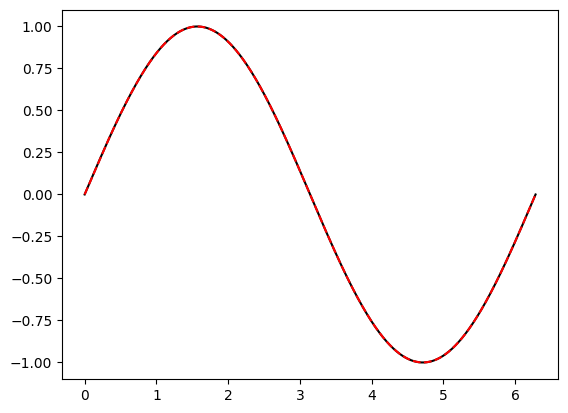

In [4]:
# Generación de datos sintéticos.
x_true = np.linspace(0, np.pi*2, 10000)
y_true = np.sin(x_true)
dy_true = np.cos(x_true)

# Definimos la estructura de la función que queremos aprender.
x = Variable('x')
y = Functional('y', x, [10, 10, 10], activation=['tanh', 'g-cos', 'l-sin'])

# Imponemos restricciones al modelo.
dy_dx = sn.diff(y, x)
c1 = Data(y)

# Definimos el modelo.
model = SciModel(x, [y, dy_dx], optimizer='adam',plot_to_file='sin.png')
model.summary()

start_time = time.time()

# Entrenamiento.
entrenamiento_sin = model.train(x_true,
            [y_true, dy_true],
            epochs=200,
            learning_rate={"scheduler": "ExponentialDecay",
                           "initial_learning_rate": 1e-3,
                           "final_learning_rate": 1e-5,
                           "decay_epochs": 10,
                           "verify": False},
            batch_size=32,
            # adaptive_weights={'method': "SASW", "eta": 0.1, "d_mask_func": lambda x: np.exp(x)},
            adaptive_weights={'method': "CLW", 'initial_weights': [0.1, 1.], 'final_weights': [2., 3.], 'curriculum_epochs': 20, "delay_epochs": 10},
            save_weights={'path': 'test', 'freq': 100}
            )

print(f"Duración del entrenamiento: {time.time()-start_time}s. ")

# Predicción
y_pred = y.eval(model, x_true)

# Mostramos los resultados
plt.plot(x_true, y_true, '-k', x_true, y_pred, '--r')
plt.show()

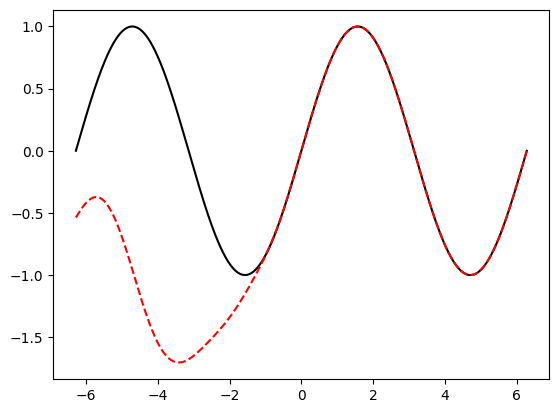

In [ ]:
x_test = np.linspace(-np.pi*2, np.pi*2, 20000)
y_test = np.sin(x_test)
y_pred_test = y.eval(model, x_test)

# Mostramos los resultados
plt.plot(x_test, y_test, '-k', x_test, y_pred_test, '--r')
plt.show()

Text(0, 0.5, 'Pérdida')

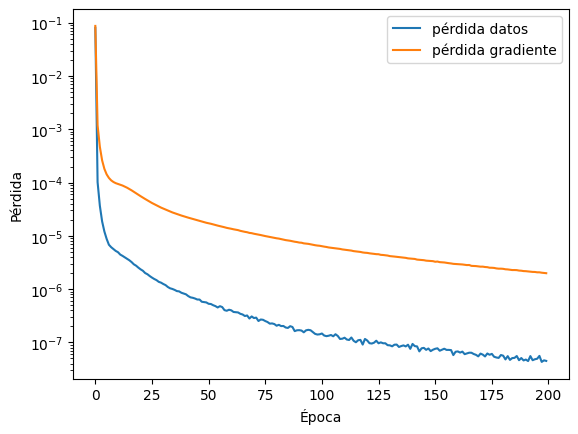

In [14]:
plt.semilogy(entrenamiento_sin.history['y_loss'],label="pérdida datos")
plt.semilogy(entrenamiento_sin.history['Grad__2_loss'],label="pérdida gradiente")
plt.legend()
plt.xlabel('Época')
plt.ylabel('Pérdida')

## 1.2. Ajuste de la curva $y = exp(x)$ en el intervalo $[0,1]$.

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 x (InputLayer)              [(None, 1)]               0         
                                                                 
 D10b_11 (Dense)             (None, 10)                20        
                                                                 
 sci_rowdy_activation_layer_  (None, 10)               3         
 6 (SciRowdyActivationLayer)                                     
                                                                 
 D10b_12 (Dense)             (None, 10)                110       
                                                                 
 sci_rowdy_activation_layer_  (None, 10)               3         
 7 (SciRowdyActivationLayer)                                     
                                                                 
 D10b_13 (Dense)             (None, 10)                110 

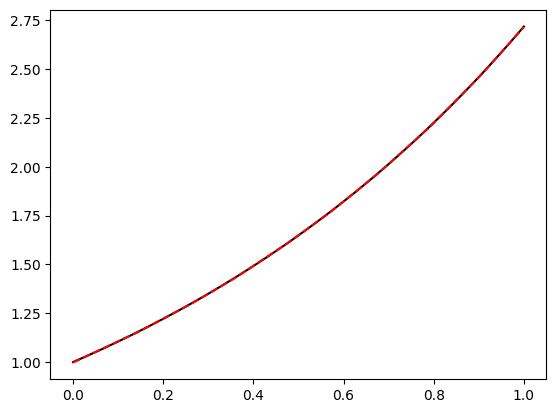

In [ ]:
# Generación de datos sintéticos.
x_true = np.linspace(0, 1, 10000)
y_true = np.exp(x_true)
dy_true = np.exp(x_true)

# Definimos la estructura de la función que queremos aprender.
x = Variable('x')
y = Functional('y', x, [10, 10, 10], activation=['relu', 'relu', 'relu'])

# Imponemos restricciones al modelo.

dy_dx = sn.diff(y, x)
c1 = Data(y)

# Definimos el modelo.
model = SciModel(x, [y, dy_dx], optimizer='adam')
model.summary()

start_time = time.time()

# Entrenamiento.
entrenamiento_exp = model.train(x_true,
            [y_true, dy_true],
            epochs=1000,
            learning_rate={"scheduler": "ExponentialDecay",
                           "initial_learning_rate": 1e-3,
                           "final_learning_rate": 1e-5,
                           "decay_epochs": 10,
                           "verify": False},
            batch_size=32,
            callbacks=[keras.callbacks.EarlyStopping(monitor="y_loss", min_delta = 0, patience=5,verbose=1)]
            )

print(f"Duración del entrenamiento: {time.time()-start_time}s. ")

# Predicción.
y_pred = y.eval(model, x_true)

# Mostramos los resultados.
plt.plot(x_true, y_true, '-k', x_true, y_pred, '--r')
plt.show()

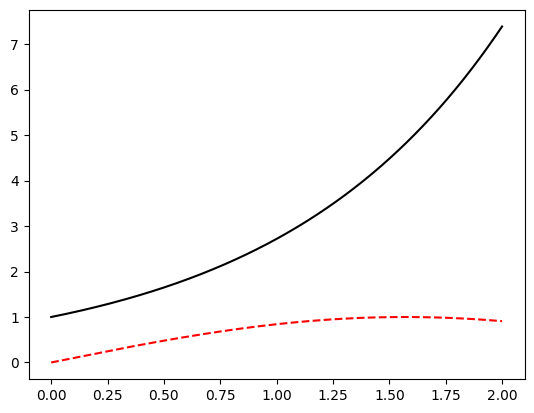

In [5]:
x_test = np.linspace(0, 2, 20000)
y_test = np.exp(x_test)
y_pred_test = y.eval(model, x_test)

# Mostramos los resultados
plt.plot(x_test, y_test, '-k', x_test, y_pred_test, '--r')
plt.show()

In [ ]:
plt.semilogy(history_2d.history['loss'])

##1.3. Ajuste de la curva $ z = \sin(x)e^{y}$, $x,y\in [0,\pi]$.

In [24]:
x_data, y_data = np.meshgrid(
    np.linspace(0, np.pi, 100),
    np.linspace(0, np.pi, 100)
)

f_data = np.sin(x_data) * np.exp(y_data)
df_dx_data = np.cos(x_data) * np.exp(y_data)
df_dy_data = np.sin(x_data) * np.exp(y_data)

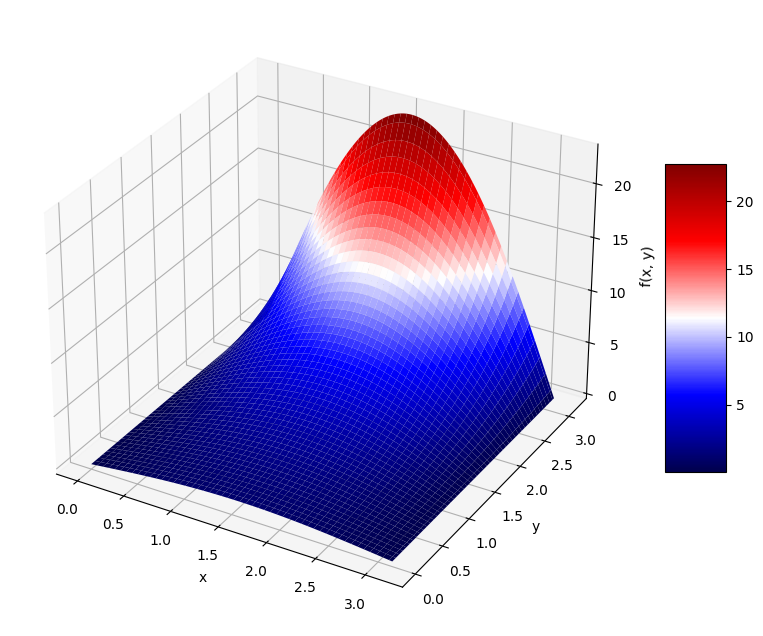

In [19]:
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

# Graficar superficie 3D
surf = ax.plot_surface(x_data, y_data, f_data, cmap='seismic', edgecolor='none')
fig.colorbar(surf, ax=ax, shrink=0.5, aspect=5)  # Añadir barra de color

# Etiquetas y título
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('f(x, y)')

# Mostrar gráfico
plt.show()

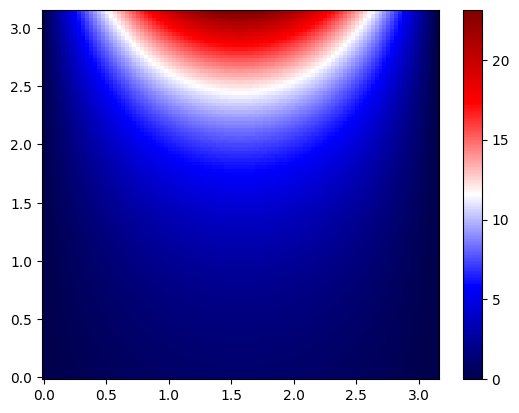

In [ ]:
plt.xlabel('Eje X')
plt.xlabel('Eje Y')
plt.pcolor(x_data, y_data, f_data, cmap='seismic')
plt.colorbar()

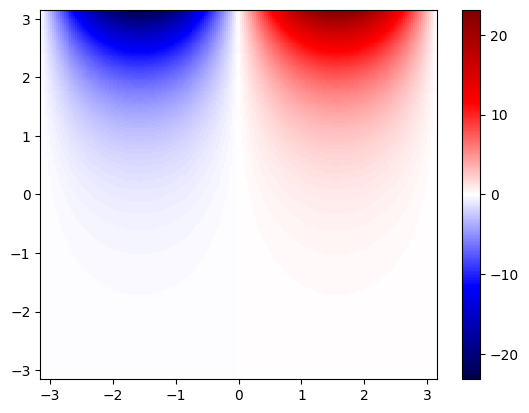

In [20]:
x_test, y_test = np.meshgrid(
    np.linspace(-np.pi, np.pi, 200),
    np.linspace(-np.pi, np.pi, 200)
)
f_test = np.sin(x_test) * np.exp(y_test)
plt.pcolor(x_test, y_test, f_test, cmap='seismic')
plt.colorbar()

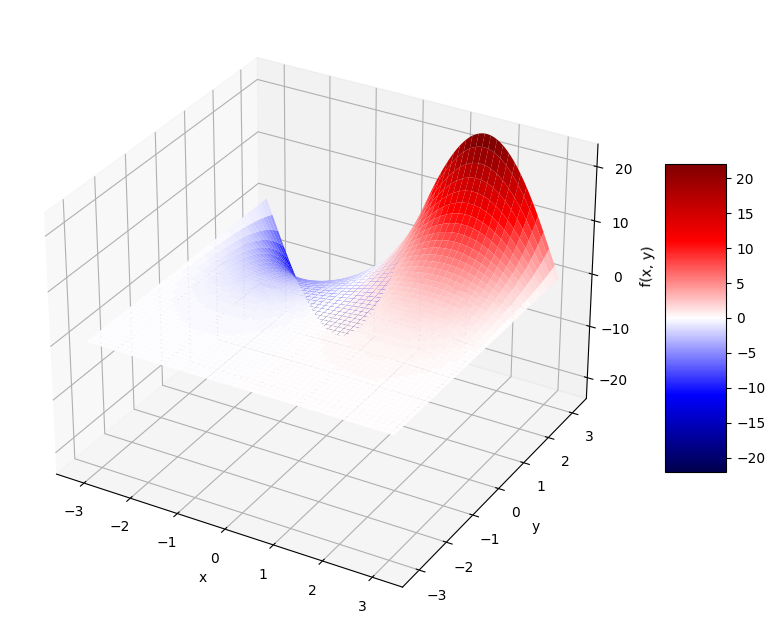

In [ ]:
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

# Graficar superficie 3D
surf = ax.plot_surface(x_test, y_test, f_test, cmap='seismic', edgecolor='none')
fig.colorbar(surf, ax=ax, shrink=0.5, aspect=5)  # Añadir barra de color

# Etiquetas y título
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('f(x, y)')

# Mostrar gráfico
plt.show()

In [22]:
x = sn.Variable('x')
y = sn.Variable('y')
f = sn.Functional('f', [x, y], [10, 10, 10, 10], 'tanh')

df_dx = sn.diff(f, x)
df_dy = sn.diff(f, y)

d1 = sn.Data(f)
modelo_2d = sn.SciModel([x,y],[f, df_dx,df_dy], plot_to_file='2D.png')

In [28]:
entrenamiento_2d = modelo_2d.train([x_data, y_data], [f_data,df_dx_data,df_dy_data], epochs=500, learning_rate={"scheduler": "ExponentialDecay",
                           "initial_learning_rate": 1e-2,
                           "final_learning_rate": 1e-4,
                           "decay_epochs": 10,
                           "verify": False},
            batch_size=32,
            callbacks=[keras.callbacks.EarlyStopping(monitor="loss", min_delta = 0, patience=10,verbose=1)])


Total samples: 10000 
Batch size: 32 
Total batches: 313 

Epoch 1/500
313/313 [==============================] - 2s 6ms/step - batch: 156.0000 - size: 31.9489 - loss: 9.1356 - f_loss: 2.0171 - Grad__7_loss: 3.7644 - Grad__8_loss: 3.3542 - lr: 0.0100 - time: 2.0146
Epoch 2/500
313/313 [==============================] - 1s 4ms/step - batch: 156.0000 - size: 31.9489 - loss: 0.1725 - f_loss: 0.0283 - Grad__7_loss: 0.0823 - Grad__8_loss: 0.0619 - lr: 0.0063 - time: 1.2901
Epoch 3/500
313/313 [==============================] - 1s 4ms/step - batch: 156.0000 - size: 31.9489 - loss: 0.0580 - f_loss: 0.0079 - Grad__7_loss: 0.0255 - Grad__8_loss: 0.0247 - lr: 0.0040 - time: 1.2482
Epoch 4/500
313/313 [==============================] - 1s 4ms/step - batch: 156.0000 - size: 31.9489 - loss: 0.0341 - f_loss: 0.0034 - Grad__7_loss: 0.0171 - Grad__8_loss: 0.0135 - lr: 0.0025 - time: 1.2478
Epoch 5/500
313/313 [==============================] - 2s 6ms/step - batch: 156.0000 - size: 31.9489 - loss: 0.0

Text(0, 0.5, 'Pérdida')

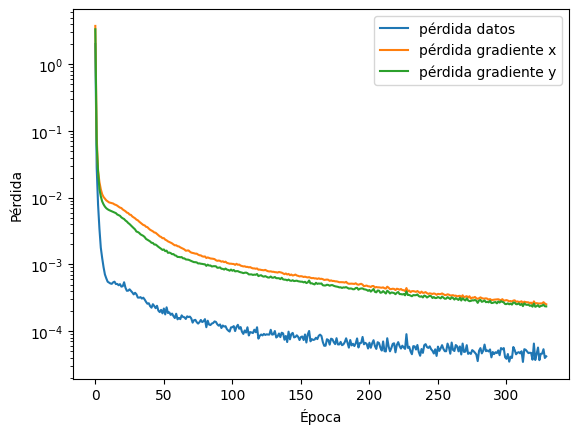

In [31]:
plt.semilogy(entrenamiento_2d.history['f_loss'],label="pérdida datos")
plt.semilogy(entrenamiento_2d.history['Grad__7_loss'],label="pérdida gradiente x")
plt.semilogy(entrenamiento_2d.history['Grad__8_loss'],label="pérdida gradiente y")

plt.legend()
plt.xlabel('Época')
plt.ylabel('Pérdida')

In [ ]:
x = sn.Variable('x')
y = sn.Variable('y')
f = sn.Functional('f', [x, y], [10, 10, 10, 10], 'tanh')

df_dx = sn.diff(f, x)
df_dy = sn.diff(f, y)

d1 = sn.Data(f)
model_2d = sn.SciModel([x, y], d1, plot_to_file='2D.png')

In [ ]:
history_2d = model_2d.train([x_data, y_data], f_data, epochs=500, learning_rate={"scheduler": "ExponentialDecay",
                           "initial_learning_rate": 1e-2,
                           "final_learning_rate": 1e-5,
                           "decay_epochs": 10,
                           "verify": False},
            batch_size=32,
            callbacks=[keras.callbacks.EarlyStopping(monitor="loss", min_delta = 0, patience=10,verbose=1)])


Total samples: 10000 
Batch size: 32 
Total batches: 313 

Epoch 1/1000
313/313 [==============================] - 1s 2ms/step - batch: 156.0000 - size: 31.9489 - loss: 1.3048 - lr: 0.0100 - time: 0.6093
Epoch 2/1000
313/313 [==============================] - 1s 2ms/step - batch: 156.0000 - size: 31.9489 - loss: 0.3291 - lr: 0.0050 - time: 0.8176
Epoch 3/1000
313/313 [==============================] - 1s 2ms/step - batch: 156.0000 - size: 31.9489 - loss: 0.1496 - lr: 0.0025 - time: 0.7563
Epoch 4/1000
313/313 [==============================] - 2s 8ms/step - batch: 156.0000 - size: 31.9489 - loss: 0.1035 - lr: 0.0013 - time: 2.4955
Epoch 5/1000
313/313 [==============================] - 1s 3ms/step - batch: 156.0000 - size: 31.9489 - loss: 0.0829 - lr: 6.3096e-04 - time: 1.1313
Epoch 6/1000
313/313 [==============================] - 2s 5ms/step - batch: 156.0000 - size: 31.9489 - loss: 0.0731 - lr: 3.1623e-04 - time: 1.6998
Epoch 7/1000
313/313 [==============================] - 2s 5ms

In [ ]:
f_pred = f.eval(model_2d, [x_test, y_test])

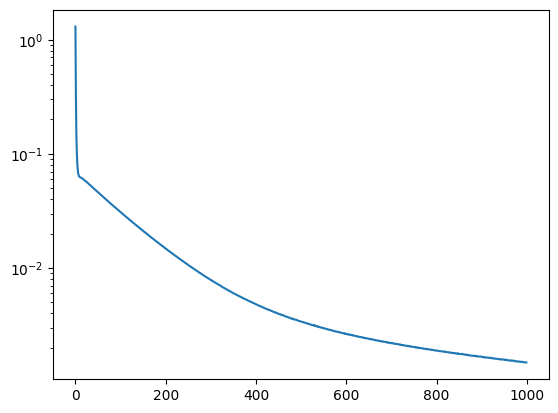

In [ ]:
plt.semilogy(history_2d.history['loss'])

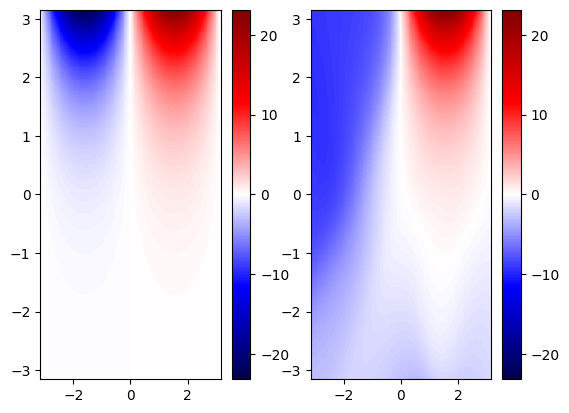

In [ ]:
vmin = min(f_test.min(), f_pred.min())
vmax = max(f_test.max(), f_pred.max())

fig, ax = plt.subplots(1, 2)

im = ax[0].pcolor(x_test, y_test, f_test, cmap='seismic', vmin=vmin, vmax=vmax)
plt.colorbar(im, ax=ax[0])

im = ax[1].pcolor(x_test, y_test, f_pred, cmap='seismic', vmin=vmin, vmax=vmax)
plt.colorbar(im, ax=ax[1])

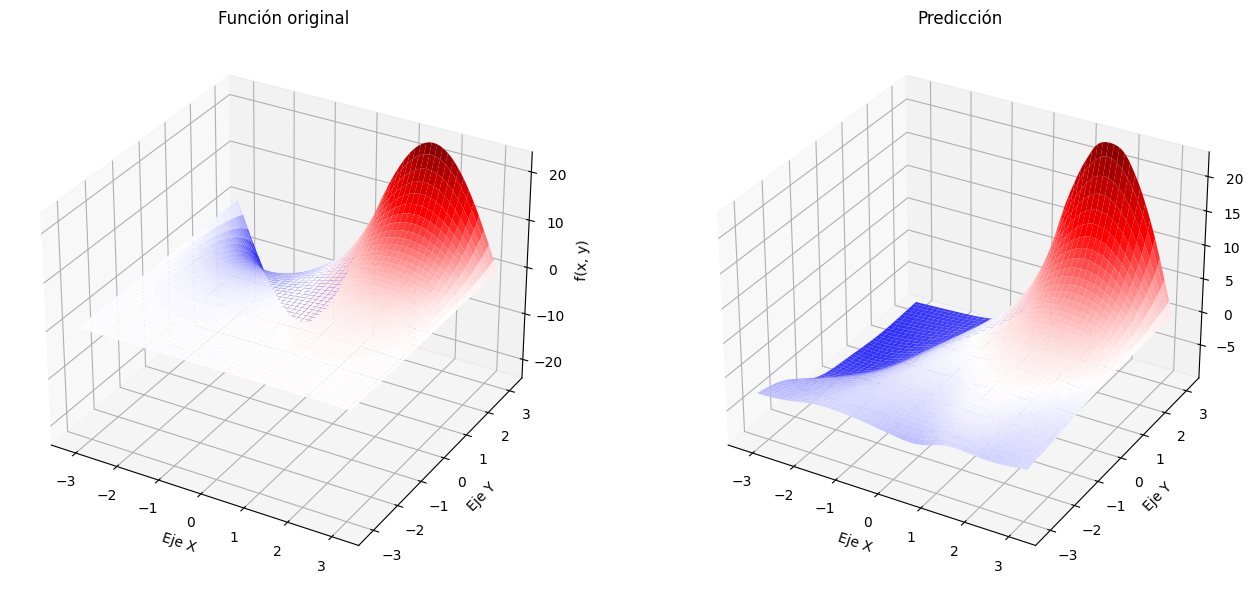

In [ ]:
# Crear figura y ejes 3D
fig = plt.figure(figsize=(14, 6))

# Primer subplot
ax1 = fig.add_subplot(121, projection='3d')
surf1 = ax1.plot_surface(x_test, y_test, f_test, cmap='seismic', edgecolor='none',vmin=vmin, vmax=vmax)
fig.colorbar(surf, ax=ax, shrink=0.5, aspect=5)
ax1.set_title('Función original')
ax1.set_xlabel('Eje X')
ax1.set_ylabel('Eje Y')
ax1.set_zlabel('f(x, y)')

# Segundo subplot
ax2 = fig.add_subplot(122, projection='3d')
surf2 = ax2.plot_surface(x_test, y_test, f_pred, cmap='seismic', edgecolor='none',vmin=vmin, vmax=vmax)
fig.colorbar(surf, ax=ax, shrink=0.5, aspect=5)
ax2.set_title('Predicción')
ax2.set_xlabel('Eje X')
ax2.set_ylabel('Eje Y')


# Ajustar diseño y mostrar gráfico
plt.tight_layout()
plt.show()

In [ ]:
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

# Graficar superficie 3D
surf = ax.plot_surface(x_data, y_data, f_data, cmap='seismic', edgecolor='none')
fig.colorbar(surf, ax=ax, shrink=0.5, aspect=5)  # Añadir barra de color

# Etiquetas y título
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('f(x, y)')

# Mostrar gráfico
plt.show()